In [1]:
!pip install -Uqq fastai
!pip install -Uqq fastai duckduckgo_search
!pip install -Uqq ipywidgets

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('cheetos', max_images=1)
urls[0]

Searching for 'cheetos'


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\duckduckgo_search\compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\duckduckgo_search\compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\duckduckgo_search\compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://i5.walmartimages.com/asr/b92439c7-c0d7-4d1a-aff8-6c92ab1e0643_1.ea53cf6c488b5d06ee38bf7eb015266a.jpeg'

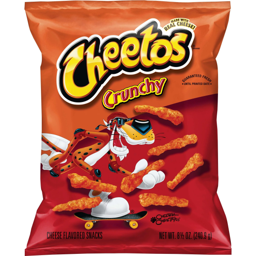

In [4]:
from fastdownload import download_url
dest = 'cheetos.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'planes photos'


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\duckduckgo_search\compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\duckduckgo_search\compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\duckduckgo_search\compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


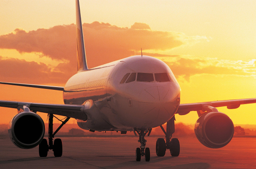

In [5]:
download_url(search_images('planes photos', max_images=1)[0], 'plane.jpg', show_progress=False)
Image.open('plane.jpg').to_thumb(256,256)

In [6]:
searches = 'plane','cheetos'
path = Path('plane_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'plane photo'
Searching for 'plane sun photo'
Searching for 'plane shade photo'
Searching for 'cheetos photo'
Searching for 'cheetos sun photo'
Searching for 'cheetos shade photo'


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

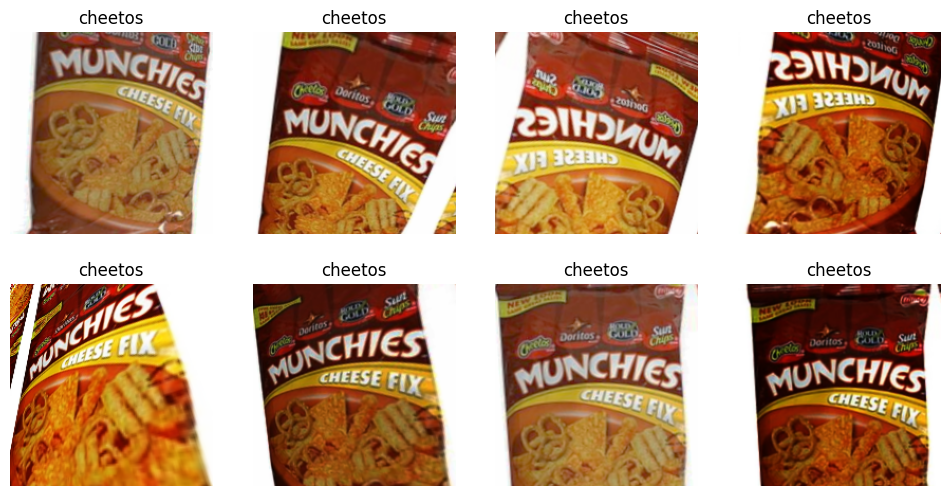

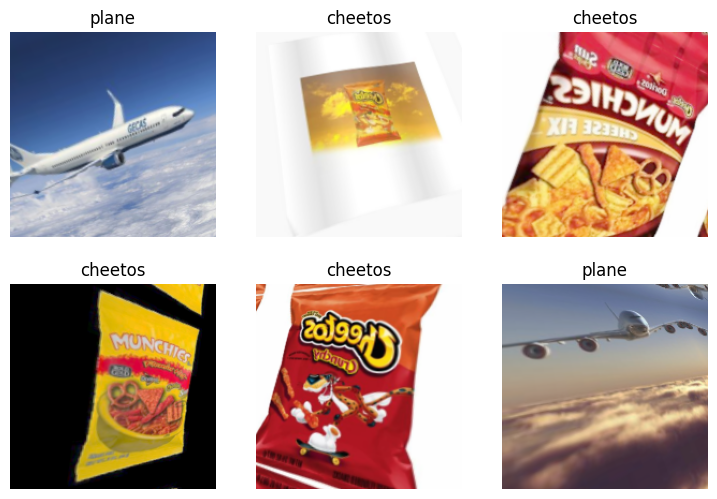

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='RandomResizedCrop')],
    batch_tfms=aug_transforms(mult=2)
).dataloaders(path, bs=32)
dls.train.show_batch(max_n=8, nrows=2, unique=True)
dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.544530,0.081927,0.030928,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.075987,0.029718,0.010309,00:20
1,0.046007,0.001343,0.000000,00:20
2,0.036154,0.002565,0.000000,00:19


In [10]:
is_plane,_,probs = learn.predict(PILImage.create('plane.jpg'))
print(f"This is a: {is_plane}.")
print(f"Probability it's a cheetos: {probs[0]:.4f}")

This is a: plane.
Probability it's a cheetos: 0.0000


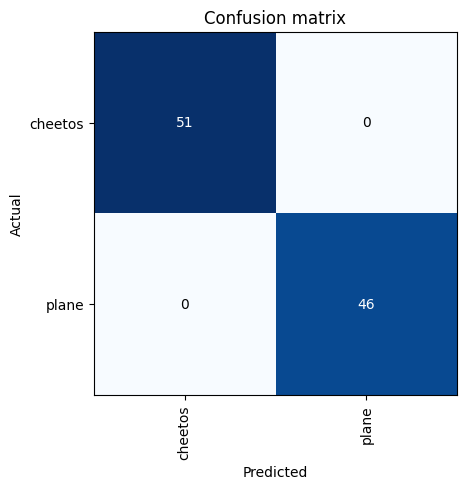

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

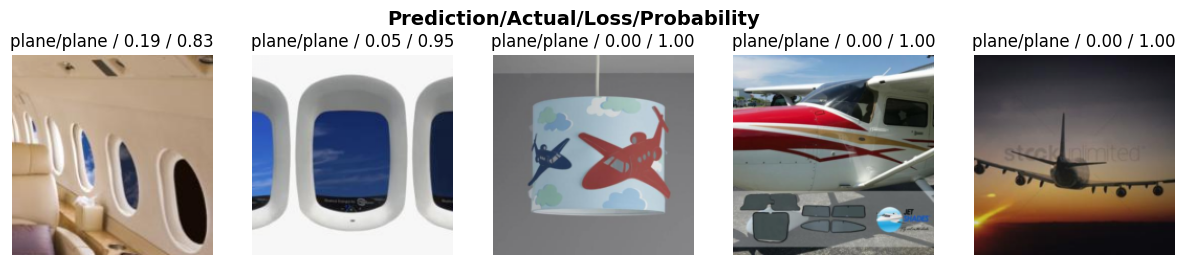

In [12]:
interp.plot_top_losses(5, nrows=1)

In [13]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner